Hipotesis: "¿Qué factores predicen si una película será rentable?".
- Clase 1: Películas con ROI > 1.5 (rentables).
- Clase 0: Películas con ROI ≤ 1.5 (no rentables).


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

**Carga CSV y análisis**

In [3]:
df = pd.read_csv('Datasets/movies_metadata.csv')
data = df[['adult', 'production_companies', 'genres', 'runtime', 'vote_average', 'vote_count', 'popularity', 'budget', 'revenue']]
print(df.columns)
print(data.columns)
data.apply(lambda x: print(x.value_counts()))

C:\Users\dekna\AppData\Local\Temp\ipykernel_16436\2861955378.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Datasets/movies_metadata.csv')


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
Index(['adult', 'production_companies', 'genres', 'runtime', 'vote_average',
       'vote_count', 'popularity', 'budget', 'revenue'],
      dtype='object')
adult
False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casin

adult                   None
production_companies    None
genres                  None
runtime                 None
vote_average            None
vote_count              None
popularity              None
budget                  None
revenue                 None
dtype: object

Convertir de json a string genres y production companies

In [4]:
import pandas as pd
import ast
# Función para extraer el primer género
def extract_first_genre(genres_str):
    try:
        # Convertir la cadena en una lista de diccionarios
        genres_list = ast.literal_eval(genres_str)
        # Extraer el nombre del primer género
        return genres_list[0]['name'] if genres_list else None
    except (ValueError, SyntaxError):
        # Manejar errores si el formato no es válido
        return None

# Aplicar la función a la columna 'genres'
data['genre'] = data['genres'].apply(extract_first_genre)
data['companies'] = data['production_companies'].apply(extract_first_genre)

#Lambda a Adult 
data['adult'] = data['adult'].apply(lambda x: 1 if x == False else 0)
# Mostrar el DataFrame resultante
data.head()

C:\Users\dekna\AppData\Local\Temp\ipykernel_16436\3526054965.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre'] = data['genres'].apply(extract_first_genre)
C:\Users\dekna\AppData\Local\Temp\ipykernel_16436\3526054965.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['companies'] = data['production_companies'].apply(extract_first_genre)
C:\Users\dekna\AppData\Local\Temp\ipykernel_16436\3526054965.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,adult,production_companies,genres,runtime,vote_average,vote_count,popularity,budget,revenue,genre,companies
0,0,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",81.0,7.7,5415.0,21.946943,30000000,373554033.0,Animation,Pixar Animation Studios
1,0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",104.0,6.9,2413.0,17.015539,65000000,262797249.0,Adventure,TriStar Pictures
2,0,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",101.0,6.5,92.0,11.7129,0,0.0,Romance,Warner Bros.
3,0,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",127.0,6.1,34.0,3.859495,16000000,81452156.0,Comedy,Twentieth Century Fox Film Corporation
4,0,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'id': 35, 'name': 'Comedy'}]",106.0,5.7,173.0,8.387519,0,76578911.0,Comedy,Sandollar Productions


**Limpieza de datos 1**

In [5]:
data['budget'] = pd.to_numeric(data['budget'], errors='coerce')
# Filtrar el DataFrame para eliminar filas con 0 en 'budget' o 'revenue'
data = data.loc[(data['budget'] != 0) & (data['revenue'] != 0)]
data = data.dropna()
# Eliminar columnas sin modificar el DataFrame original
data = data.drop(columns=['production_companies', 'genres', 'vote_count', 'popularity'])

# Eliminar filas donde 'companies' aparece solo una vez
companies_to_remove = data['companies'].value_counts()[data['companies'].value_counts() == 1].index
data = data[~data['companies'].isin(companies_to_remove)]
data.value_counts()
data.drop_duplicates()



C:\Users\dekna\AppData\Local\Temp\ipykernel_16436\637723409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['budget'] = pd.to_numeric(data['budget'], errors='coerce')


,adult,runtime,vote_average,budget,revenue,genre,companies
0,0,81.0,7.7,30000000.0,373554033.0,Animation,Pixar Animation Studios
1,0,104.0,6.9,65000000.0,262797249.0,Adventure,TriStar Pictures
3,0,127.0,6.1,16000000.0,81452156.0,Comedy,Twentieth Century Fox Film Corporation
5,0,170.0,7.7,60000000.0,187436818.0,Action,Regency Enterprises
8,0,106.0,5.5,35000000.0,64350171.0,Action,Universal Pictures
...,...,...,...,...,...,...,...
45014,0,95.0,5.7,60000000.0,71000000.0,Action,Imagine Entertainment
45139,0,86.0,5.8,50000000.0,66913939.0,Comedy,Columbia Pictures
45167,0,111.0,7.4,11000000.0,184770205.0,Action,Thunder Road Pictures
45250,0,185.0,6.9,12000000.0,19000000.0,Action,AVM Productions


****

**Transformar columnas**

In [6]:
# Convertir las columnas 'genre' y 'companies' en variables dummies
data = pd.get_dummies(data, columns=['genre', 'companies'], drop_first=True)
# Eliminar las columnas 'genre' y 'companies' de la data
data.head()

,adult,runtime,vote_average,budget,revenue,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,...,companies_Winkler Films,companies_Wonderland Sound and Vision,companies_Working Title Films,companies_Worldview Entertainment,companies_X-Filme Creative Pool,companies_Yari Film Group,companies_Yash Raj Films,companies_Zentropa Entertainments,companies_Zoetrope Studios,companies_icon
0,0,81.0,7.7,30000000.0,373554033.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,104.0,6.9,65000000.0,262797249.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,127.0,6.1,16000000.0,81452156.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5,0,170.0,7.7,60000000.0,187436818.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,0,106.0,5.5,35000000.0,64350171.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Calculo variables objetivo**

In [7]:
# Calcular ROI: (revenue - budget) / budget
data['ROI'] = (data['revenue'] - data['budget']) / data['budget']
# Crear variable binaria
data['ROI_Class'] = (data['ROI'] > 0).astype(int)

**Seleccion de variable objetivo y división datos**

In [8]:
# Seleccionar variables independientes (X) y la variable objetivo (y)
X = data.drop(columns=["ROI", "ROI_Class"])  # Variables predictoras
y = data["ROI_Class"]  # Variable objetivo binaria
# Preprocesamiento
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

**Balanceo de clases y evaluación mejor modelo**

In [9]:
# --------------------
# MÉTODOS DE BALANCEO DE CLASES
# --------------------
# 1. Sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# 2. SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. Submuestreo aleatorio
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# 4. NearMiss (submuestreo basado en distancia)
nearmiss = NearMiss()
X_train_nm, y_train_nm = nearmiss.fit_resample(X_train, y_train)

# --------------------
# EVALUACIÓN DE MÉTODOS DE BALANCEO
# --------------------
resultados_balanceo = {}

def evaluar_balanceo(X_train_resampled, y_train_resampled, metodo):
    model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) * 100
    resultados_balanceo[metodo] = (f1, auc)
    print(f"\nResultados con {metodo}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"AUC-ROC: {auc:.2f}%")

evaluar_balanceo(X_train_ros, y_train_ros, "Sobremuestreo Aleatorio")
evaluar_balanceo(X_train_smote, y_train_smote, "SMOTE")
evaluar_balanceo(X_train_rus, y_train_rus, "Submuestreo Aleatorio")
evaluar_balanceo(X_train_nm, y_train_nm, "NearMiss")

# Seleccionar el mejor método de balanceo
mejor_metodo = max(resultados_balanceo, key=lambda k: resultados_balanceo[k])
print(f"\nEl mejor método de balanceo es: {mejor_metodo} con F1-Score: {resultados_balanceo[mejor_metodo][0]:.2f}% y AUC-ROC: {resultados_balanceo[mejor_metodo][1]:.2f}%")

# Obtener los datos balanceados del mejor método encontrado
if mejor_metodo == "Sobremuestreo Aleatorio":
    X_train_resampled, y_train_resampled = X_train_ros, y_train_ros
elif mejor_metodo == "SMOTE":
    X_train_resampled, y_train_resampled = X_train_smote, y_train_smote
elif mejor_metodo == "Submuestreo Aleatorio":
    X_train_resampled, y_train_resampled = X_train_rus, y_train_rus
elif mejor_metodo == "NearMiss":
    X_train_resampled, y_train_resampled = X_train_nm, y_train_nm



Resultados con Sobremuestreo Aleatorio:
Accuracy: 83.53%
Precision: 93.26%
Recall: 83.62%
F1-Score: 88.18%
AUC-ROC: 88.13%

Resultados con SMOTE:
Accuracy: 82.59%
Precision: 92.70%
Recall: 82.83%
F1-Score: 87.49%
AUC-ROC: 88.28%

Resultados con Submuestreo Aleatorio:
Accuracy: 77.10%
Precision: 92.70%
Recall: 74.72%
F1-Score: 82.75%
AUC-ROC: 85.81%

Resultados con NearMiss:
Accuracy: 68.93%
Precision: 90.42%
Recall: 64.55%
F1-Score: 75.32%
AUC-ROC: 80.18%

El mejor método de balanceo es: Sobremuestreo Aleatorio con F1-Score: 88.18% y AUC-ROC: 88.13%


**Ajuste de manual de hiperparámetros**

In [10]:
# --------------------
# MÉTODO 1: Ajuste manual de hiperparámetros
# --------------------
manual_model = LogisticRegression(C=10, solver='lbfgs', max_iter=500)  # Ejemplo de hiperparámetros ajustados manualmente
manual_model.fit(X_train_resampled, y_train_resampled)  # Entrenar modelo
# Predicciones
y_pred_manual = manual_model.predict(X_test)

# Evaluación del modelo ajustado manualmente
print("\nResultados con ajuste manual de hiperparámetros:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, manual_model.predict_proba(X_test)[:,1]) * 100:.2f}%")



Resultados con ajuste manual de hiperparámetros:
Accuracy: 91.36%
Precision: 95.87%
Recall: 92.21%
F1-Score: 94.00%
AUC-ROC: 96.09%


**Ajuste automático**

In [11]:
# --------------------
# MÉTODO 2: Ajuste automático con GridSearchCV
# --------------------
parametros = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Diferentes valores de regularización
    "solver": ["liblinear", "lbfgs"]  # Diferentes algoritmos de optimización
}

# Configurar GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=500), parametros, cv=5, scoring="accuracy", n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)  # Entrenar búsqueda de hiperparámetros

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test)

# Evaluación del mejor modelo
print("\nResultados con ajuste automático de hiperparámetros:")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor Accuracy en validación cruzada: {grid_search.best_score_ * 100:.2f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_best) * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_best) * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]) * 100:.2f}%")



Resultados con ajuste automático de hiperparámetros:
Mejores parámetros: {'C': 10, 'solver': 'lbfgs'}
Mejor Accuracy en validación cruzada: 95.27%
Accuracy: 91.36%
Precision: 95.87%
Recall: 92.21%
F1-Score: 94.00%
AUC-ROC: 96.09%


**Entrenamiento del mejor modelo ncontrado con la busqueda automática**
- El modelo ya se ha configurado de la mejor forma psoible en la celda anterior

In [12]:
# --------------------
# ENTRENAMIENTO FINAL Y EVALUACIÓN
# --------------------

# Entrenar el mejor modelo con los datos balanceados
best_model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones finales con el mejor modelo y el mejor balanceo
y_pred_final = best_model.predict(X_test)

# Crear DataFrame de resultados
resultados = pd.DataFrame({
    "Real": y_test.values,
    "Predicción": y_pred_final
})

# Mapear valores 0 y 1 a etiquetas comprensibles
resultados["Real"] = resultados["Real"].map({0: "Non purchased", 1: "Purchased"})
resultados["Predicción"] = resultados["Predicción"].map({0: "Non purchased", 1: "Purchased"})

print(f"Mejor Accuracy en validación cruzada: {grid_search.best_score_ * 100:.2f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_best) * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_best) * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]) * 100:.2f}%")

Mejor Accuracy en validación cruzada: 95.27%
Accuracy: 91.36%
Precision: 95.87%
Recall: 92.21%
F1-Score: 94.00%
AUC-ROC: 96.09%


**Gráfico 1: Matriz de Confusión (Medición del Desempeño del Modelo)**

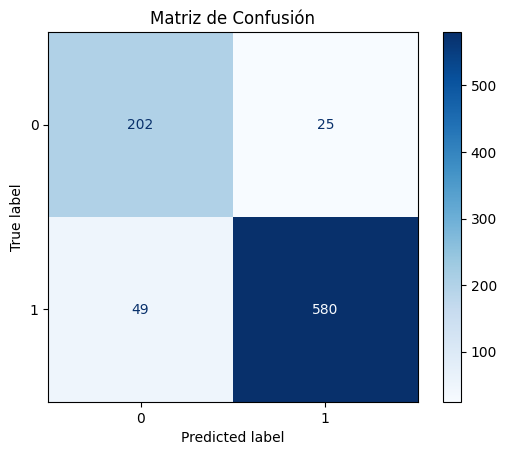

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predecir las etiquetas para el conjunto de prueba
y_pred = best_model.predict(X_test)

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()


**Gráfico 2: Curva ROC (Medición de Separación de Clases)**


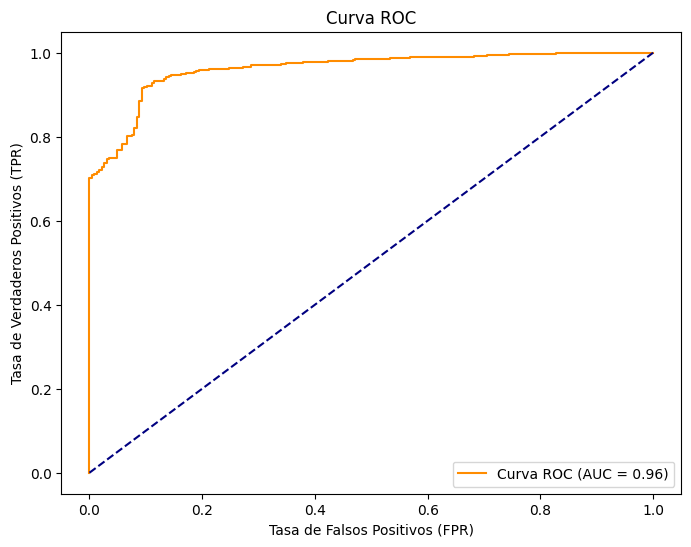

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predecir probabilidades para la clase positiva
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


Prueba de balanceo de clases


In [13]:
""""from imblearn.under_sampling import RandomUnderSampler


# Realizar predicciones finales con el mejor modelo y el mejor balanceo
y_pred_final = best_model.predict(X_test)

# Crear DataFrame de resultados
resultados = pd.DataFrame({
    "Real": y_test.values,
    "Predicción": y_pred_final
})

# Mapear valores 0 y 1 a etiquetas comprensibles
resultados["Real"] = resultados["Real"].map({0: "Non purchased", 1: "Purchased"})
resultados["Predicción"] = resultados["Predicción"].map({0: "Non purchased", 1: "Purchased"})
print(f"Mejor Accuracy en validación cruzada: {grid_search.best_score_ * 100:.2f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_best) * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_best) * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]) * 100:.2f}%")""""

Mejor Accuracy en validación cruzada: 95.27%
Accuracy: 91.36%
Precision: 95.87%
Recall: 92.21%
F1-Score: 94.00%
AUC-ROC: 96.09%


En la **Regresión Logística Binaria**, el objetivo es predecir una variable categórica con dos posibles resultados (por ejemplo, **sí/no**, **0/1**, **positivo/negativo**).  

### 📊 **Métricas importantes:**  
1. **Accuracy (Exactitud):**  
   - Proporción de predicciones correctas sobre el total.  
   - Ej: Si el modelo predice bien 80 de 100 muestras, la accuracy es 0.8 (80%).  
   - Limita su interpretación cuando las clases están desbalanceadas.  

2. **Precision (Precisión):**  
   - Proporción de verdaderos positivos (TP) sobre todos los que fueron predichos como positivos (TP + FP).  
   - Mide cuántas de las predicciones positivas son realmente correctas.  
   - Útil cuando el costo de un falso positivo es alto.  

3. **Recall (Sensibilidad o Tasa de Verdaderos Positivos):**  
   - Proporción de verdaderos positivos (TP) sobre todos los elementos que realmente son positivos (TP + FN).  
   - Mide cuántos de los verdaderos positivos son detectados correctamente.  
   - Útil cuando el costo de un falso negativo es alto.  

4. **F1-Score:**  
   - Media armónica entre Precision y Recall.  
   - Balancea ambos aspectos cuando hay un desbalance entre clases.  
   - \( \text{F1} = 2 \times \frac{(\text{Precision} \times \text{Recall})}{(\text{Precision} + \text{Recall})} \)  

5. **Matriz de Confusión:**  
   - Tabla que muestra TP, TN (verdaderos negativos), FP (falsos positivos) y FN (falsos negativos).  
   - Ayuda a visualizar el rendimiento completo del modelo.  

6. **AUC-ROC (Área bajo la curva - Característica Operativa del Receptor):**  
   - Mide la capacidad del modelo para distinguir entre las clases.  
   - Un valor de 1 indica una clasificación perfecta, mientras que 0.5 es como adivinar al azar.  

7. **Log-Loss (Pérdida Logarítmica):**  
   - Evalúa la probabilidad asignada a cada predicción, penalizando fuertemente las malas predicciones con alta confianza.  
   - Cuanto menor sea el Log-Loss, mejor.  

¿Te ayudo a implementar esto con tu dataset? 😊